In [1]:
#pip install tensorflow

In [2]:
#pip install matplotlib

In [3]:
#pip install climetlab

In [4]:
#pip install climetlab-eumetnet-postprocessing-benchmark

In [5]:
#pip install --upgrade jupyterlab ipywidgets

In [6]:
#pip install requests

In [7]:
#pip install tensorrt

In [8]:
#pip install plotly


In [9]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib  # For saving scaler model
import os
import plotly.graph_objects as go
import pandas as pd

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

2024-04-29 14:26:27.892991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:26:28.892857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
class ScaledModel:
    def __init__(self, sequence_length, param, feature_count, hours_to_predict):
        self.sequence_length = sequence_length
        self.param = param
        self.feature_count = feature_count
        self.hours_to_predict = hours_to_predict
        self.scaler = MinMaxScaler()
        self.model = self._build_model()
        self.X_test = None  # Initialize X_test
        self.y_test = None  # Initialize y_test

    def _build_model(self):
        model = Sequential([
            ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu',
                       input_shape=(self.sequence_length, 1, 1, self.feature_count), return_sequences=True),
            ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(self.hours_to_predict)
        ])
        optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def fit(self, df, epochs, batch_size, validation_split=0.2):
        df_scaled = self.scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        train_idx = int(len(df_scaled) * (1 - validation_split))
        
        train_df = df_scaled.iloc[:train_idx]
        test_df = df_scaled.iloc[train_idx:]
        
        X_train, y_train = self.create_sequences(train_df)
        X_test, y_test = self.create_sequences(test_df)

        self.X_test = X_test.reshape((X_test.shape[0], self.sequence_length, 1, 1, X_train.shape[2]))
        self.y_test = y_test
        
        # Reshape for ConvLSTM
        X_train = X_train.reshape((X_train.shape[0], self.sequence_length, 1, 1, X_train.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], self.sequence_length, 1, 1, X_test.shape[2]))
        
        checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path, save_weights_only=True,
            monitor='val_loss', mode='min', save_best_only=True, verbose=1
        )
        
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                       validation_data=(X_test, y_test), callbacks=[checkpoint])

    def evaluate(self):
        y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test, y_pred)
        return {"MSE": mse, "RMSE": rmse, "MAE": mae}
        
    def create_sequences(self, input_data, include_target=True):
        X, y = [], []
        for i in range(len(input_data) - self.sequence_length - self.hours_to_predict + 1):  # Adjusted for 24 hours ahead
            X.append(input_data.iloc[i:(i + self.sequence_length)].values)
            if include_target:
                y.append(input_data.iloc[i + self.sequence_length:i + self.sequence_length + self.hours_to_predict][self.param].values)  # 24 hours target
        if include_target:
            return np.array(X), np.array(y)
        else:
            return np.array(X)  # Return only X if include_target is False

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        self.model.save(os.path.join(path, 'model.keras'))
        joblib.dump(self.scaler, os.path.join(path, 'scaler.pkl'))

    def load_model_and_scaler(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model.keras'))
        self.scaler = joblib.load(os.path.join(path, 'scaler.pkl'))

    def predict_next_24_hours(self, latest_data):
        # Assume latest_data is preprocessed and scaled appropriately
        df_scaled = self.scaler.transform(latest_data)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        latest_sequence = df_scaled.tail(self.sequence_length).values.reshape(1, self.sequence_length, 1, 1, self.feature_count)
        future_temperatures = self.model.predict(latest_sequence)
        dummy_output_array = np.zeros((self.hours_to_predict, self.scaler.n_features_in_))
        dummy_output_array[:, 3] = future_temperatures
        return self.scaler.inverse_transform(dummy_output_array)[:, 3]


    def predict(self, df):
        df_scaled = self.scaler.transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
        X = self.create_sequences(df_scaled, include_target=False)
        X = X.reshape((X.shape[0], self.sequence_length, 1, 1, X.shape[2]))
        prediction_scaled = self.model.predict(X)
        dummy_output_array = np.zeros((prediction_scaled.shape[0], self.scaler.n_features_in_))
        dummy_output_array[:, 3] = prediction_scaled[:, 0]
        return self.scaler.inverse_transform(dummy_output_array)[:, 3]


    def plot_predictions(self, y_test, y_pred):
        plt.figure(figsize=(15, 6))
        # Line plot of the actual vs predicted
        plt.subplot(1, 2, 1)
        plt.plot(y_test, label='Actual', linestyle='-')
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.title('Detailed View of Predictions vs. Actual')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        
        # Scatter plot of the actual vs predicted
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.title('Prediction vs Actual')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line
        
        plt.tight_layout()
        plt.show()

    def evaluate_and_plot(self):
        y_pred = self.model.predict(self.X_test).flatten()
        y_test = self.y_test.flatten()  # Ensure y_test is flat if it's not already
        dummy_array = np.zeros((y_pred.shape[0], self.feature_count))
        dummy_array[:, 3] = y_pred.squeeze() 
        test_dummy_array = np.zeros((y_test.shape[0], self.feature_count))
        test_dummy_array[:, 3] = y_test.squeeze()  
        test_y = self.scaler.inverse_transform(test_dummy_array)[:, 3]
        predictions_y = self.scaler.inverse_transform(dummy_array)[:, 3]

        metrics = self.evaluate()  # Calling evaluate to use existing evaluation metrics
        print("Mean Squared Error:", metrics['MSE'])
        print("Root Mean Squared Error:", metrics['RMSE'])
        print("Mean Absolute Error:", metrics['MAE'])
        self.plot_predictions(test_y, predictions_y)




In [11]:

def fetch_data(start_date = '2018-01-01', end_date='2024-01-01'):
    url_template = ("https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?"
                    "parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&"
                    "parameters=RH2M&parameters=UU&parameters=VV&start={start_date}T00%3A00&"
                    "end={end_date}T00%3A00&lat_lon=48.333056%2C16.631944&"
                    "lat_lon=48.115278%2C16.175833&output_format=geojson&"
                    "filename=INCA_Vienna_timeseries_all_parameters_{start_year}_{end_year}_0101")
    formatted_url = url_template.format(start_date=start_date, end_date=end_date, 
                                        start_year=start_date[:4], end_year=end_date[:4])
    print(formatted_url)
    response = requests.get(formatted_url)
    if response.status_code == 200:
        data = response.json()
        print("Fetched data successfully")
    else:
        print("Failed to retrieve data", response.status_code)

    # Processing the data
    data_list = []
    for feature in data['features']:
        location = feature['geometry']['coordinates']
        for i, timestamp in enumerate(data['timestamps']):
            record = {
                'time': pd.to_datetime(timestamp),
                'longitude': location[0],
                'latitude': location[1],
                'RR': feature['properties']['parameters']['RR']['data'][i],
                'T2M': feature['properties']['parameters']['T2M']['data'][i],
                'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
                'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
                'GL': feature['properties']['parameters']['GL']['data'][i],
                'UU': feature['properties']['parameters']['UU']['data'][i],
                'VV': feature['properties']['parameters']['VV']['data'][i],
                'P0': feature['properties']['parameters']['P0']['data'][i]
            }
            data_list.append(record)

    original_df = pd.DataFrame(data_list)
    return original_df


In [12]:
def calculate_rolling_features(df, window_size, feature_name):
    if len(df) < window_size:
        window_size = len(df)  # Adjust window size to length of the data if data is too short
    df[f'{feature_name}_rolling_mean'] = df['T2M'].rolling(window=window_size).mean()
    df[f'{feature_name}_rolling_max'] = df['T2M'].rolling(window=window_size).max()
    df[f'{feature_name}_rolling_min'] = df['T2M'].rolling(window=window_size).min()
    df[f'{feature_name}_rolling_std'] = df['T2M'].rolling(window=window_size).std()

def calculate_ewm_features(df, span, feature_name):
    df[f'{feature_name}_ewm'] = df['T2M'].ewm(span=span, adjust=False).mean()

def handle_na(df):
    df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
    df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain

def feature_engineering(df):
    df.dropna(inplace=True)  # Drop rows with NaN values first
    original_time_index = df['time'].copy()
    # Basic date-time features
    df['hour'] = df['time'].dt.hour
    df['day_of_year'] = df['time'].dt.dayofyear
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_month'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year

    # Wind and interaction features
    df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
    df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi
    df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
    df['wind_rain_interaction'] = df['wind_speed'] * df['RR']
    df['RR_lag1'] = df['RR'].shift(1)
    df['T2M_lag1'] = df['T2M'].shift(1)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)

    # Rolling and EWMA features
    calculate_rolling_features(df, 6, '6h')  # 24-hour window
    calculate_rolling_features(df, 12, '12h')  # 24-hour window
    calculate_rolling_features(df, 24, '24h')  # 24-hour window
    calculate_rolling_features(df, 24*7, '7d')  # 7-day window
    calculate_ewm_features(df, 6, '6h')  # EWMA for 24 hours
    calculate_ewm_features(df, 12, '12h')  # EWMA for 24 hours
    calculate_ewm_features(df, 24, '24h')  # EWMA for 24 hours
    calculate_ewm_features(df, 24*7, '7d')  # EWMA for 7 days

    # Handle NaNs intelligently
    handle_na(df)

    # Ensure only numeric types are used for modeling
    df = df.select_dtypes(include=[np.number])
    
    return df, original_time_index

In [13]:
def get_data_for_convlstm(start_date, end_date):
    df, time_index = feature_engineering(fetch_data(start_date, end_date).copy())
    return df, time_index

In [14]:
preprocessed_df = fetch_data().copy()

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2024_0101
Fetched data successfully


In [15]:
preprocessed_df_copy = preprocessed_df.copy()

In [16]:
feature_df, time_index  = feature_engineering(preprocessed_df)

/tmp/ipykernel_10523/421820632.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
/tmp/ipykernel_10523/421820632.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain


In [17]:
feature_df_copy = feature_df.copy

In [18]:
df = feature_df.copy()
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,24h_rolling_min,24h_rolling_std,7d_rolling_mean,7d_rolling_max,7d_rolling_min,7d_rolling_std,6h_ewm,12h_ewm,24h_ewm,7d_ewm
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.680000,1.680000,1.680000,1.680000
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.534286,1.601538,1.639200,1.673964
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.210204,1.416686,1.540064,1.658888
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.010146,1.277196,1.457659,1.645292
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,0.40,2.713545,4.803274,9.19,-0.35,2.445896,0.861533,1.156089,1.380246,1.631620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,-0.91,1.274571,6.981190,14.18,-0.91,3.909641,1.796285,1.701230,2.314958,5.679273
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,-0.91,1.239458,6.933988,14.18,-0.91,3.915498,2.000204,1.825656,2.330561,5.641766
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,-0.91,1.166241,6.878810,14.18,-0.91,3.921609,1.954431,1.827863,2.291316,5.596775
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,-0.91,1.281970,6.835119,14.18,-0.91,3.907203,2.673165,2.234345,2.465611,5.583441


In [19]:
param = 'T2M'
sequence_length = 24
feature_count = df.shape[1]
hours_to_predict = 6
print("Number of features:", feature_count)


Number of features: 48


In [30]:
scaled_model = ScaledModel(sequence_length=sequence_length, param=param, feature_count=feature_count, hours_to_predict=hours_to_predict)
scaled_model.fit(df, epochs=3, batch_size=32)

# To save model and scaler
#scaled_model.save('saved_model_scaler_6h')

/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3


2024-04-29 14:33:16.927828: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 387343872 exceeds 10% of free system memory.


2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0084
Epoch 1: val_loss improved from inf to 0.00106, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - loss: 0.0083 - val_loss: 0.0011
Epoch 2/3
2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.0437e-04
Epoch 2: val_loss improved from 0.00106 to 0.00075, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - loss: 9.0434e-04 - val_loss: 7.5287e-04
Epoch 3/3
2625/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.8205e-04
Epoch 3: val_loss did not improve from 0.00075
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 7.8203e-04 - val_loss: 7.6091e-04


In [21]:
import os

# Directory to check
directory = 'saved_model_scaler_6h'  # Make sure this is the directory you saved the files in

# Check if the directory exists
if os.path.exists(directory):
    # List contents of the directory
    print("Directory contents:", os.listdir(directory))
else:
    print("Directory does not exist:", directory)


Directory contents: ['model.keras', 'scaler.pkl']


In [22]:
scaled_model.save('6h_model_new')


In [25]:
scaled_model = tf.keras.models.load_model(os.path.join('6h_model_new', 'model.keras'))

657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Squared Error: 0.0007609086814905659
Root Mean Squared Error: 0.027584573251920465
Mean Absolute Error: 0.019551194611846845
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Squared Error: 0.0007609086814905659
Root Mean Squared Error: 0.027584573251920465
Mean Absolute Error: 0.019551194611846845


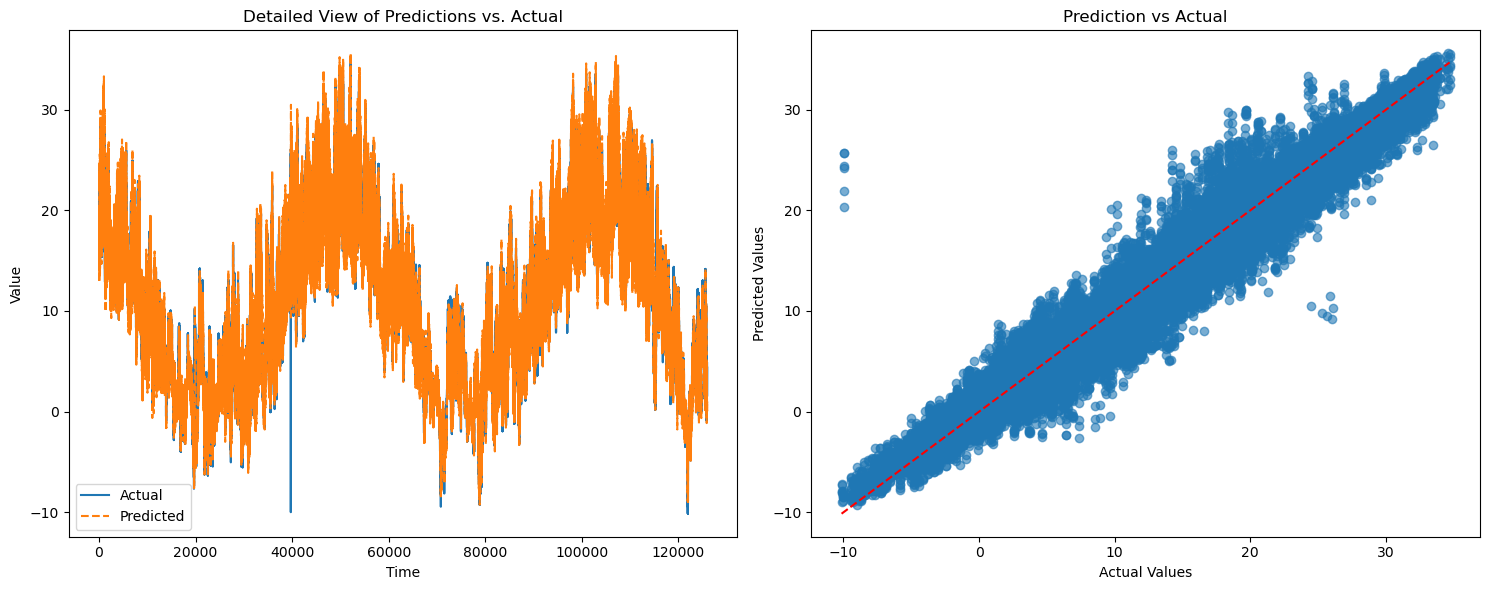

In [31]:
metrics = scaled_model.evaluate()
print("Mean Squared Error:", metrics['MSE'])
print("Root Mean Squared Error:", metrics['RMSE'])
print("Mean Absolute Error:", metrics['MAE'])
scaled_model.evaluate_and_plot()

In [32]:
data_for_prediction, time_index_pre_data = get_data_for_convlstm('2023-06-14', '2023-06-18')


https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2023-06-14T00%3A00&end=2023-06-18T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2023_2023_0101
Fetched data successfully


/tmp/ipykernel_10523/421820632.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
/tmp/ipykernel_10523/421820632.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain


In [28]:

predicted_temps = scaled_model.predict_(data_for_prediction)
print("Predicted temperatures for the next 24 hours:", predicted_temps)


AttributeError: 'Sequential' object has no attribute 'predict_'

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-04-25T00%3A00&end=2024-04-29T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2024_2024_0101
Fetched data successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/tmp/ipykernel_10523/421820632.py:13: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_10523/421820632.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



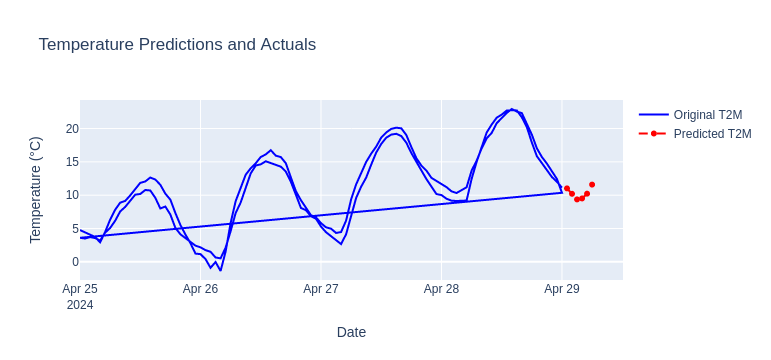

In [34]:
#Example data setup (you should replace this with your actual data loading)
data_for_prediction, time_index_pre_data = get_data_for_convlstm('2024-04-25', '2024-04-29')
predicted_temps = scaled_model.predict_next_24_hours(data_for_prediction)

# Use the original indices for plotting
data_for_prediction.index = time_index_pre_data
last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Create Plotly graph objects
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=data_for_prediction.index, y=data_for_prediction['T2M'],
                         mode='lines', name='Original T2M', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicted T2M'],
                         mode='lines+markers', name='Predicted T2M', line=dict(color='red', dash='dash')))

# Update layout for better visualization
fig.update_layout(
    title='Temperature Predictions and Actuals',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    hovermode="x unified"
)

# Show plot
fig.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data for initial prediction period along with their original time indices
data_for_prediction, time_index_pre_data = get_data_for_convlstm('2024-04-23', '2024-04-27')

# Prediction with the scaled model
predicted_temps = scaled_model.predict_next_24_hours(data_for_prediction)
print("Predicted temperatures for the next 24 hours:", predicted_temps)

# Set the original time index for the initial prediction data
data_for_prediction.index = time_index_pre_data

# Generate timestamps for the predictions, starting right after the last timestamp of the historical data
last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)

# Create DataFrame for the predictions
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Load actual data for the prediction period along with their original time indices
data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm('2023-06-27', '2023-06-28')
data_actual_for_prediction.index = time_index_actual_data

# Combine the historical and prediction data for plotting
combined_df = pd.concat([data_for_prediction, data_actual_for_prediction, predictions_df])

# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(data_for_prediction.index, data_for_prediction['T2M'], label='Original T2M', color='blue')
#plt.plot(data_actual_for_prediction.index, data_actual_for_prediction['T2M'], label='Actual T2M', color='green')
plt.plot(predictions_df.index, predictions_df['Predicted T2M'], label='Predicted T2M', color='red', linestyle='--')
plt.title('Temperature Predictions and Actuals')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

print("Last historical timestamp:", data_for_prediction.index[-1])
print("First historical timestamp:", data_for_prediction.index[0])
print("First prediction timestamp:", predictions_df.index[0])
print("Number of predictions:", len(predicted_temps))


NameError: name 'get_data_for_convlstm' is not defined

In [97]:
print(data_for_prediction)

print("Last historical timestamp:", data_for_prediction.index[-1])
print("first historical timestamp:", data_for_prediction.index[0])
print("First prediction timestamp:", predictions_df.index[0])
print("Number of predictions:", len(predicted_temps))


                     longitude   latitude   RR    T2M   RH2M   TD2M      GL  \
2023-06-24 00:00:00  16.638773  48.334339  0.0  14.82  90.82  13.34    0.00   
2023-06-24 01:00:00  16.638773  48.334339  0.0  13.99  91.70  12.66    0.00   
2023-06-24 02:00:00  16.638773  48.334339  0.0  13.62  94.95  12.83    0.00   
2023-06-24 03:00:00  16.638773  48.334339  0.0  13.28  96.96  12.80    0.00   
2023-06-24 04:00:00  16.638773  48.334339  0.0  13.39  95.58  12.70   72.52   
2023-06-24 05:00:00  16.638773  48.334339  0.0  16.10  84.26  13.45  153.26   
2023-06-24 06:00:00  16.638773  48.334339  0.0  18.86  73.84  14.09  372.78   
2023-06-24 07:00:00  16.638773  48.334339  0.0  20.90  64.24  13.89  526.17   
2023-06-24 08:00:00  16.638773  48.334339  0.0  22.58  57.89  13.87  670.40   
2023-06-24 09:00:00  16.638773  48.334339  0.0  23.91  50.38  12.97  710.91   
2023-06-24 10:00:00  16.638773  48.334339  0.0  25.04  45.51  12.45  708.66   
2023-06-24 11:00:00  16.638773  48.334339  0.0  25.8

In [90]:
dummy_output_array = np.zeros((predicted_temps.shape[0], scaled_model.scaler.n_features_in_))
dummy_output_array[:, 3] = predicted_temps.squeeze()
predictions = scaled_model.scaler.inverse_transform(dummy_output_array)[:, 3]

In [110]:
print("Total rows in data_for_prediction:", len(data_for_prediction))
print("Total rows in df:", len(df))


Total rows in data_for_prediction: 50
Total rows in df: 105110


In [111]:
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,7d_rolling_mean,7d_rolling_max,7d_rolling_min,7d_rolling_std,24h_ewm,7d_ewm
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.680000,1.680000
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.639200,1.673964
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.540064,1.658888
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.457659,1.645292
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,3.458333,7.97,0.40,2.713545,4.803274,9.19,-0.35,2.445896,1.380246,1.631620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,1.450000,3.45,-0.91,1.274571,6.981190,14.18,-0.91,3.909641,2.314958,5.679273
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,1.420417,3.45,-0.91,1.239458,6.933988,14.18,-0.91,3.915498,2.330561,5.641766
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,1.353333,3.12,-0.91,1.166241,6.878810,14.18,-0.91,3.921609,2.291316,5.596775
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,1.409583,4.47,-0.91,1.281970,6.835119,14.18,-0.91,3.907203,2.465611,5.583441


In [112]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[23.298254534602172, 23.412202072739607, 23.600298631787307, 23.66304106891156, 23.76015

In [113]:
print("First timestamp:", data_for_prediction.index.min())
print("Last timestamp:", data_for_prediction.index.max())
print("Unique timestamps count:", data_for_prediction.index.nunique())


First timestamp: 0
Last timestamp: 49
Unique timestamps count: 50


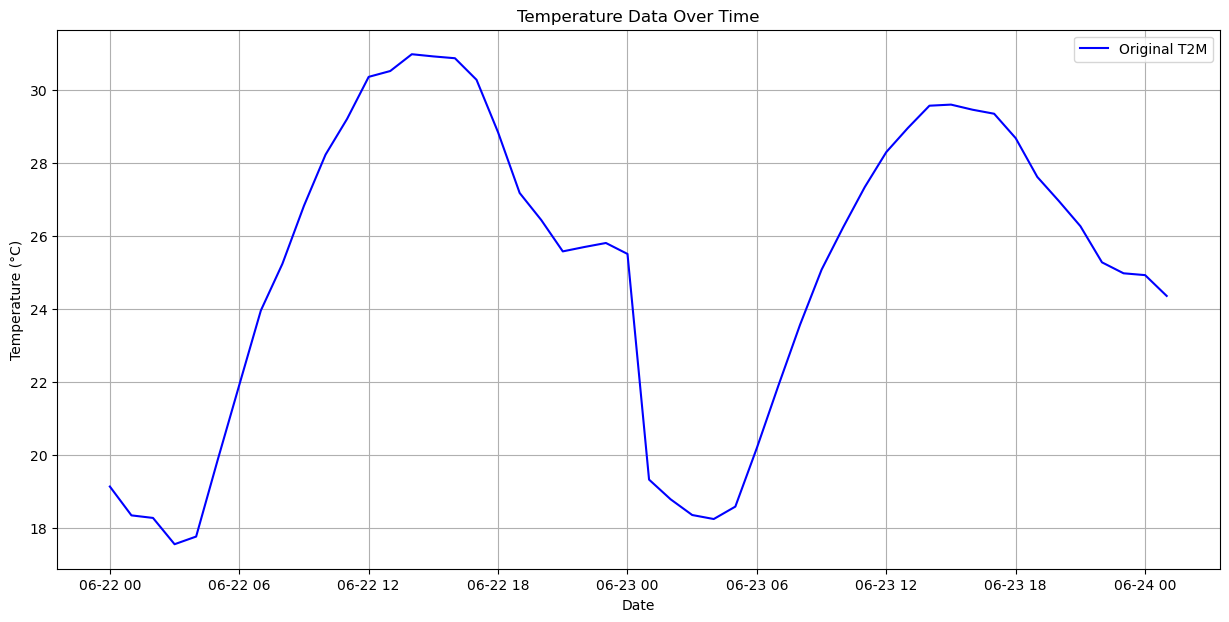

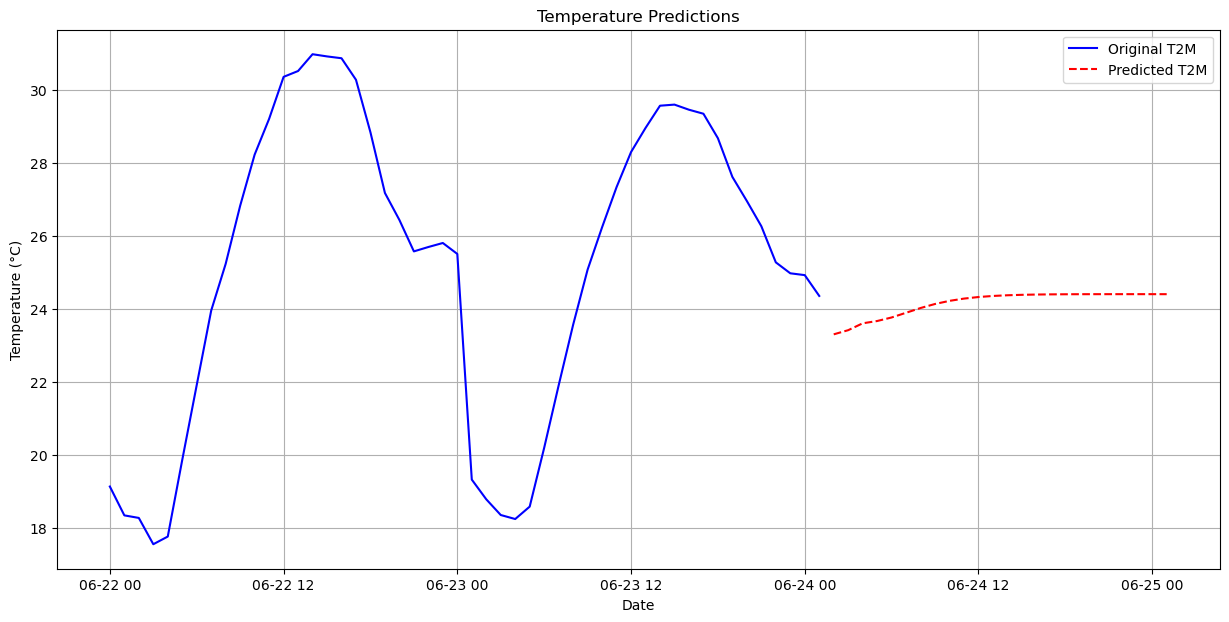

In [114]:
start_datetime = '2023-06-22 00:00:00'

# Generate a datetime index starting from `start_datetime`
new_index = pd.date_range(start=start_datetime, periods=data_for_prediction.index.nunique(), freq='H')  # 'H' for hourly

# Assign this new index to your DataFrame
data_for_prediction.index = new_index

# Now plot as before
plt.figure(figsize=(15, 7))
plt.plot(data_for_prediction.index, data_for_prediction['T2M'], label='Original T2M', color='blue')
plt.title('Temperature Data Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'  # 'H' for hourly

# Generate new timestamps for predictions
new_timestamps = pd.date_range(start=last_timestamp, periods=len(predictions) + 1, freq=prediction_frequency)[1:]

# Continue as previously to plot predictions alongside original data
predictions_df = pd.DataFrame(predictions, index=new_timestamps, columns=['Predicted T2M'])
combined_df = pd.concat([data_for_prediction, predictions_df])

plt.figure(figsize=(15, 7))
plt.plot(combined_df.index, combined_df['T2M'], label='Original T2M', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted T2M'], label='Predicted T2M', color='red', linestyle='--')
plt.title('Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()



In [19]:
        # Optionally, you can plot the predictions - Adjust plotting to handle scaled values if needed
        plt.figure(figsize=(10, 5))
        actual_scaled = self.scaler.inverse_transform(df_scaled)[:, 3]  # Assuming index 3 is the feature being predicted
        plt.plot(range(len(actual_scaled)), actual_scaled, label='Original data')
        plt.plot(range(len(actual_scaled), len(actual_scaled) + steps), predictions, label='Predicted data')
        plt.legend()
        plt.show()
    

NameError: name 'self' is not defined

<Figure size 1000x500 with 0 Axes>

In [20]:
data_for_prediction, time_index = get_data_for_convlstm('2024-02-02', '2024-02-03')
print("Scaler min values:", scaled_model.scaler.min_)
print("Scaler scale values:", scaled_model.scaler.scale_)
def scale_temperature(T, min_temp=-10, scale=45):
    return (T - min_temp) / scale

# Test the scaling
scaled_minus_10 = scale_temperature(-10)  # Expected to be 0
scaled_35 = scale_temperature(35)         # Expected to be 1
scaled_20 = scale_temperature(20)         # Expected to be 1
scaled_5 = scale_temperature(-5)         # Expected to be 1

scaled_minus_10, scaled_35, scaled_20, scaled_5


https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-02-02T00%3A00&end=2024-02-03T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2024_2024_0101
Fetched data successfully
Scaler min values: [-3.53499231e+01 -2.16755805e+02  0.00000000e+00  3.04614206e-01
 -1.45475372e-01  4.40229598e-01  0.00000000e+00  4.34725849e-01
  5.07621951e-01 -1.56912065e+01  0.00000000e+00 -1.92307692e-02
 -9.09090909e-02  0.00000000e+00  4.99844830e-01  3.98302190e-01
  0.00000000e+00  0.00000000e+00  3.04614206e-01  5.00000000e-01
  5.00000000e-01 -2.73972603e-03  5.00000000e-01  4.99990740e-01
  3.04532032e-01]
Scaler scale values: [2.18465167e+00 4.50519876e+00 2.00224251e-02 1.91460846e-02
 1.14547537e-02 2.49563264e-02 9.83448561e-04 4.35161010e-02
 5.08130081e-02 1.

(0.0, 1.0, 0.6666666666666666, 0.1111111111111111)

In [21]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[8.641888642013077, 8.091706206798559, 7.745983050167565, 7.56692396730185, 7.4777228632

In [33]:
predic = scaled_model.predict(data_for_prediction.copy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


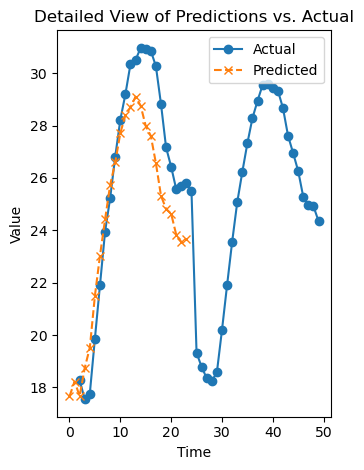

In [36]:
plt.subplot(1, 2, 1)
plt.plot(data_for_prediction['T2M'], label='Actual', marker='o', linestyle='-')
plt.plot(predic, label='Predicted', marker='x', linestyle='--')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Scatter plot of the actual vs predicted
plt.tight_layout()
plt.show()

In [24]:
predictions = scaled_model.predict_future(data_for_prediction.copy().iloc[-48:], steps=24)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [25]:
predictions = scaled_model.predict_future(feature_df.copy().iloc[-24:], steps=6)
print("Predictions for the next 6 time points:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions for the next 6 time points: [4.805448871254925, 5.434960609972482, 5.207949668467049, 4.659613331556325, 4.152384591698651, 3.835319542884831]
